# Future UK Housing Price Prediction by Li Lu

The project aims at predicting the future housing price using three features which are the lease duration, the property type, and whether or not the property is in London. In order to deal with the large data, I firstly used Dask dataframe for data pre-processing. I aggregated the data according to the three features as well as grouping them into monthly data since there were less fluctuations compared with daily data.  After plotting ACF and PACF, I found there were yearly seasonal pattern. The three features made up a total of 16 classes and I used seasonal ARIMA model to fit the price for each class. The standardised RMSE was used to evaluate the result. The mean RMSE of training set is 1.33, and the mean RMSE of test set is 0.99, which proved that there was no overfitting of the model.


## Pre-Processing

In [ ]:
### Pre-processing to the data

# The housing price data could be downloaded from https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads
# The button is "the complete Price Paid Transaction Data as a CSV file" and it is about 4.3GB

# The Dask dataframe allows me to manipulate and aggregating the dataset without explicitly running them. I can therefore use
# it to aggregate dataset until it becomes smaller and can be fit into the RAM of my laptop, which I will then compile it 

import dask.dataframe as dd
ddf = dd.read_csv("D:/pp-complete.csv", header=None)
ddf_selected = ddf.iloc[:,[1,2,4,6,11]].copy()
ddf_selected.columns = ['Price', 'Date', 'Type','Lease','Location']
ddf_selected['In_London_or_Not'] = 0
ddf_selected['In_London_or_Not'] = ddf_selected['In_London_or_Not'].mask(ddf_selected['Location'] != "LONDON", 'N')
ddf_selected['In_London_or_Not'] = ddf_selected['In_London_or_Not'].mask(ddf_selected['Location'] == "LONDON", 'L')
ddf_selected['Date'] = dd.to_datetime(ddf_selected.Date).dt.to_period('M')
ddf_final = ddf_selected.iloc[:,[0,1,2,3,5]].copy()


In [ ]:
# Splitting the data into years
startyear = 1995
for i in range(26):
    year = startyear+i
    start_date = str(year)+'-01'
    end_date = str(year)+'-12'
    mask = (ddf_final['Date'] >= start_date) & (ddf_final['Date'] <= end_date)
    ddf_yearly = ddf_final.loc[mask]
    ddf_yearly_agg = ddf_yearly.groupby(['Date','Type','Lease','In_London_or_Not']).agg(['mean', 'count'])
    ddf_yearly_agg.columns = [ ' '.join(str(i) for i in col) for col in ddf_yearly_agg.columns]
    ddf_yearly_agg=ddf_yearly_agg.reset_index()
    filename = 'D:/HousingPriceYearly1/' + str(year) + 'housing.csv'
    ddf_yearly_agg.compute().to_csv(filename, index = False, header=True)

In [34]:
# Bring all the different years of data back and concatenate them
import pandas as pd
import numpy as np
startyear = 1995
mydf = pd.DataFrame()
for i in range(26):
    year = startyear + i
    filename = 'D:/HousingPriceYearly1/' + str(year) + 'housing.csv'
    tempdf = pd.read_csv(filename)
    mydf = mydf.append(tempdf,ignore_index = True)
# Removing the category that has very few purchases/sellings, to reduce noise
mask = (mydf['Type'] != 'O') & (mydf['Lease'] != 'U')
mydf = mydf.loc[mask].reset_index(level=0, drop=True).reset_index(drop=True)
mydf

,Date,Type,Lease,In_London_or_Not,Price mean,Price count
0,1995-01,D,F,L,271140.210526,95
1,1995-01,D,F,N,106155.468463,10686
2,1995-01,D,L,L,701673.500000,4
3,1995-01,D,L,N,82976.115663,415
4,1995-01,F,F,L,211748.148148,27
...,...,...,...,...,...,...
4953,2020-12,S,F,N,324708.593750,128
4954,2020-12,S,L,N,195750.000000,7
4955,2020-12,T,F,L,999166.666667,12
4956,2020-12,T,F,N,224469.857988,169


In [35]:
mydf['Category'] = ''
for i in mydf['Type'].unique():
    for j in mydf['Lease'].unique():
        for k in mydf['In_London_or_Not'].unique():
            mask = (mydf['Type'] == i) & (mydf['Lease']==j) & (mydf['In_London_or_Not'] == k)
            mydf.loc[mask,'Category'] = 'Type_' + i +'_Lease_' + j + '_London_' + k 
mydf2 = mydf.iloc[:,[0,6,4]]
mydf2 = mydf2.sort_values(['Category', 'Date'], ascending=[True, True]).reset_index(drop=True)

In [36]:
Date_Cat = pd.DataFrame()
for i in mydf2.Category.unique():
    tempdf = pd.DataFrame()
    tempdf['Date'] = pd.date_range(start='1995-01', end='2021-1',freq = 'M').to_period("M").to_series().astype(str)
    tempdf['Category'] = i
    Date_Cat = Date_Cat.append(tempdf,ignore_index = True)


In [37]:
mydf3 = Date_Cat.merge(mydf2, on=['Date','Category'], how='left')
mydf4 =  mydf3.groupby('Category').apply(lambda df1: df1.interpolate())
mydf4

,Date,Category,Price mean
0,1995-01,Type_D_Lease_F_London_L,271140.210526
1,1995-02,Type_D_Lease_F_London_L,283177.419355
2,1995-03,Type_D_Lease_F_London_L,261597.517241
3,1995-04,Type_D_Lease_F_London_L,317357.783784
4,1995-05,Type_D_Lease_F_London_L,265273.990476
...,...,...,...
4987,2020-08,Type_T_Lease_L_London_N,140510.793463
4988,2020-09,Type_T_Lease_L_London_N,146873.208200
4989,2020-10,Type_T_Lease_L_London_N,143817.699753
4990,2020-11,Type_T_Lease_L_London_N,147695.000000


## Data exploration


In [5]:
# I found that basically only 16 classes can be produced by those 3 features, which is not enough for performing prediction. 
# Therefore, I decided to use past prices together with time series model for the prediction as well.

# Divide the dataset into training set and test set
training_set = mydf4[mydf4.Date < '2019-01']
test_set = mydf4[mydf4.Date >= '2019-01']

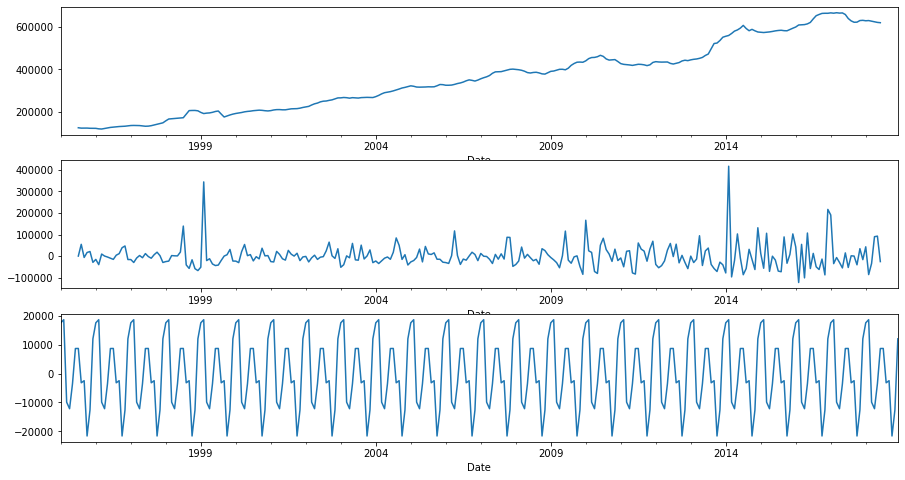

In [6]:
# Plot trend, residual and seasonal patterns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
df_train = pd.DataFrame()
df_train['Category'] = training_set['Category']
df_train['Price'] = training_set['Price mean']
df_train.index = pd.to_datetime(training_set.Date)
df_train_month = df_train.groupby("Date").agg("mean")
result = seasonal_decompose(df_train_month, model='addative',period = 12)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (15,8))
result.trend.plot(ax=ax1)
result.resid.plot(ax=ax2)
result.seasonal.plot(ax = ax3)
plt.show()
df_test = pd.DataFrame()
df_test['Category'] = test_set['Category']
df_test['Price'] = test_set['Price mean']
df_test.index = pd.to_datetime(test_set.Date)

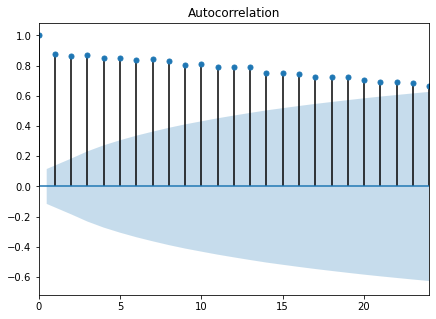

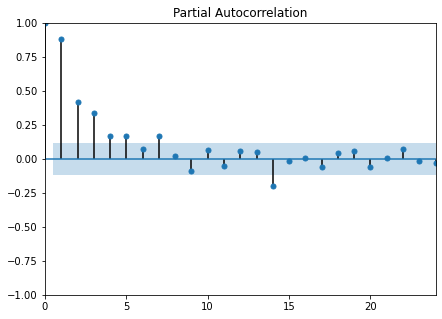

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=7,5
plot_acf(df_train_month); plt.xlim(0,24); plt.show()
plot_pacf(df_train_month); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

## Model Building

In [8]:
# Data Preparation, split them by class
zip_dfs = []
zip_dftest = []
zip_list = df_train.Category.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(df_train[df_train['Category']==x][['Price']].copy()))
    zip_dftest.append(pd.DataFrame(df_test[df_test['Category']==x][['Price']].copy()))

In [10]:
# From the ACF plot, I believe that there will be more AR terms in the model, this is why I chose the p,d,q parameters this way
import itertools 
d = q = range(0,2)
p = range(0,3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import statsmodels.api as sm
ans = []
for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                            order = para1,
                                            seasonal_order = para2,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue
                    


In [14]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
# Choosing best parameters using AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
best_para

,name,pdq,pdqs,AIC
143,Type_D_Lease_F_London_L,"(2, 1, 1)","(2, 1, 1, 12)",6812.721135
275,Type_D_Lease_F_London_N,"(2, 1, 0)","(2, 1, 1, 12)",5059.463778
431,Type_D_Lease_L_London_L,"(2, 1, 1)","(2, 1, 1, 12)",7639.354299
563,Type_D_Lease_L_London_N,"(2, 1, 0)","(2, 1, 1, 12)",5262.757885
719,Type_F_Lease_F_London_L,"(2, 1, 1)","(2, 1, 1, 12)",6819.030046
863,Type_F_Lease_F_London_N,"(2, 1, 1)","(2, 1, 1, 12)",5187.453566
1007,Type_F_Lease_L_London_L,"(2, 1, 1)","(2, 1, 1, 12)",5607.845989
1139,Type_F_Lease_L_London_N,"(2, 1, 0)","(2, 1, 1, 12)",4741.642330
1295,Type_S_Lease_F_London_L,"(2, 1, 1)","(2, 1, 1, 12)",6102.382638
1438,Type_S_Lease_F_London_N,"(2, 1, 1)","(2, 1, 0, 12)",4571.309018


## Model evaluation

In [30]:
# Testing the model by predicting the results for 2017-01 to 2018-12
summary = pd.DataFrame()
Category = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start='2017-01-01', dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['Price']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())/(zip_truth).std()
    
    Category.append(name)
    MSE_Value.append(sqrt_mse)
    
summary['Category'] = Category
summary['RMSE'] = MSE_Value

In [32]:
summary

,Category,RMSE
0,Type_D_Lease_F_London_L,1.020206
1,Type_D_Lease_F_London_N,1.197379
2,Type_D_Lease_L_London_L,1.260592
3,Type_D_Lease_L_London_N,0.894331
4,Type_F_Lease_F_London_L,0.850924
5,Type_F_Lease_F_London_N,1.004785
6,Type_F_Lease_L_London_L,1.398923
7,Type_F_Lease_L_London_N,2.178232
8,Type_S_Lease_F_London_L,1.467453
9,Type_S_Lease_F_London_N,1.121870


In [31]:
summary['RMSE'].mean()

1.3304536955270736

In [23]:
#Final Evaluation, forecasting prediction from the training model for 2019-01 to 2020-12
forecast_table = pd.DataFrame()
MSE_Value = []


for zipcode, output, df , dftest in zip(Category, models, zip_dfs, zip_dftest):
    pred_20192020 = output.get_forecast(steps = 24)
    pred_conf_20192020 = pred_20192020.conf_int()
    forecast = pred_20192020.predicted_mean
    zip_truth = dftest['2019-01-01':]['Price']
    sqrt_mse = np.sqrt(((forecast - zip_truth)**2).mean())/(zip_truth).std()
    MSE_Value.append(sqrt_mse)
forecast_table['Category'] = Category
forecast_table['RMSE'] = MSE_Value



In [24]:
forecast_table

,Category,RMSE
0,Type_D_Lease_F_London_L,1.112657
1,Type_D_Lease_F_London_N,0.798132
2,Type_D_Lease_L_London_L,1.064349
3,Type_D_Lease_L_London_N,1.000551
4,Type_F_Lease_F_London_L,1.256021
5,Type_F_Lease_F_London_N,0.850559
6,Type_F_Lease_L_London_L,1.000424
7,Type_F_Lease_L_London_N,1.306228
8,Type_S_Lease_F_London_L,0.854666
9,Type_S_Lease_F_London_N,0.998802


In [33]:
forecast_table['RMSE'].mean()

0.9927852643005904